# Period Finding: A specific case ($a^x\ mod\ 15$)

We must import all the essential packages for the correct implementation of the code.

In [204]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile

import numpy as np
import matplotlib.pyplot as plt

from math import gcd
from fractions import Fraction
from collections import defaultdict

First of all, the quantum circuit (data qubits) is to be set in a superposition state using Hadamard gates, as it is a necessary condition for the set-up.

In [205]:
def superposition(circuit, num_qubits):
    """
    this function applies Hadamard gates to each qubit in the circuit and returns the circuit updated
    
    circuit: quantum circuit
    num_qbits: number of qubits used for the circuit 
    """
    for i in range(num_qubits):
        circuit.h(i)
    return circuit

Now, the controlled gate must be prepared. In this portion, regarding Shor's algorithm, a modular exponentiation is requested. A specific case for $a^x\ mod\ 15$ here. So, this function $f: Z \Longrightarrow Z$ can be made periodic with the advantage of modular arithmetic ($mod\ N$). Code obtained from: https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

In [206]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate() 
    U.name = "%i^%i mod 15" % (a, power)
    control_U = U.control()
    return control_U

The following cell is only used in order to draw how each operator $U$ considered is created, which gates compose it. In this case, the operator for base 2 is presented.

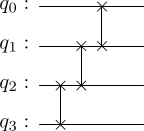

In [207]:
# Create a quantum circuit with 4 qubits
qc = QuantumCircuit(4)

# Apply the SWAP and NOT operations representing the operator for 2^x
qc.swap(2,3)
qc.swap(1,2)
qc.swap(0,1)

# Draw the circuit 
qc.draw('latex')

Now, there is a need to create a recursivity into applying this controlled gate into the circuit. This way we can obtain the gates $U$, $U^2$, $U^4$ and so on.

In [208]:
def c_U(circuit, num_qubits, a):
    """
    this function applies the controlled gate in the circuit
    
    circuit: quantum circuit
    num_qbits: number of qubits used for the circuit
    a: base of the modular exponentiation term
    """
    for qubit in range(num_qubits):
        controlled = c_amod15(a, 2**qubit) 
        circuit.append(controlled, [qubit] + [l+num_qubits for l in range(4)])
    return circuit

The $|\psi>$ state is also needed for the algorithm. This state is where the controlled gates will be placed (target qubits), and a "phase kickback" will return the phase transformation to the data qubits. It must be an eigenvector of controlled operator $U$.

In [209]:
def psi(circuit, num_qubits, a):
    """
    this function creates the state psi, which is the eigenvector of the controlled gate

    circuit: quantum circuit
    num_qubits: number of qubits used for the circuit
    a: base of the modular exponentiation term
    """
    # Create 00...001 in target register, eigenvalue of U
    circuit.x(num_qubits) 
    circuit.barrier()
    circuit = c_U(circuit, num_qubits, a)
    return circuit

The QFT inverse must be applied in order to discern the phase from the several operations done before (QFT method used). This is the last operation needed before measuring, and it is applied into the data qubits. All individual operations are structured. The final step before initializing the circuit is to arrange them in an orderly manner in order to apply correctly the Quantum Phase Estimation algorithm.

In [210]:
def qpe(circuit, num_qubits, a):
    """
    all the previous function are orderly applied creating the Quantum Phase Estimation algorithm

    circuit: quantum circuit
    num_qubits: number of qubits used for the circuit
    a: base of the modular exponentiation term
    """
    circuit = superposition(circuit, num_qubits)
    circuit = psi(circuit, num_qubits, a)
    circuit.barrier()
    circuit.append(QFT(num_qubits, inverse=True).to_gate(label="QFT†"), range(num_qubits))
    circuit.barrier()
    circuit.measure(range(num_qubits), range(num_qubits))
    return circuit

Now then, all operations established, it is time to initialize the circuit for a given conditions.

In [211]:
def random_a(N):
    """
    this function returns a random value of a following:
        · a < N 
        · gcd(a,N) == 1
    
    N: modulo factor used

    returns: a random value that satisfies the conditions
    """
    while True:
        a = np.random.randint(2,N)
        if gcd(a,N) == 1:
            break
    return a

The exponential selected is: 13^x mod 15


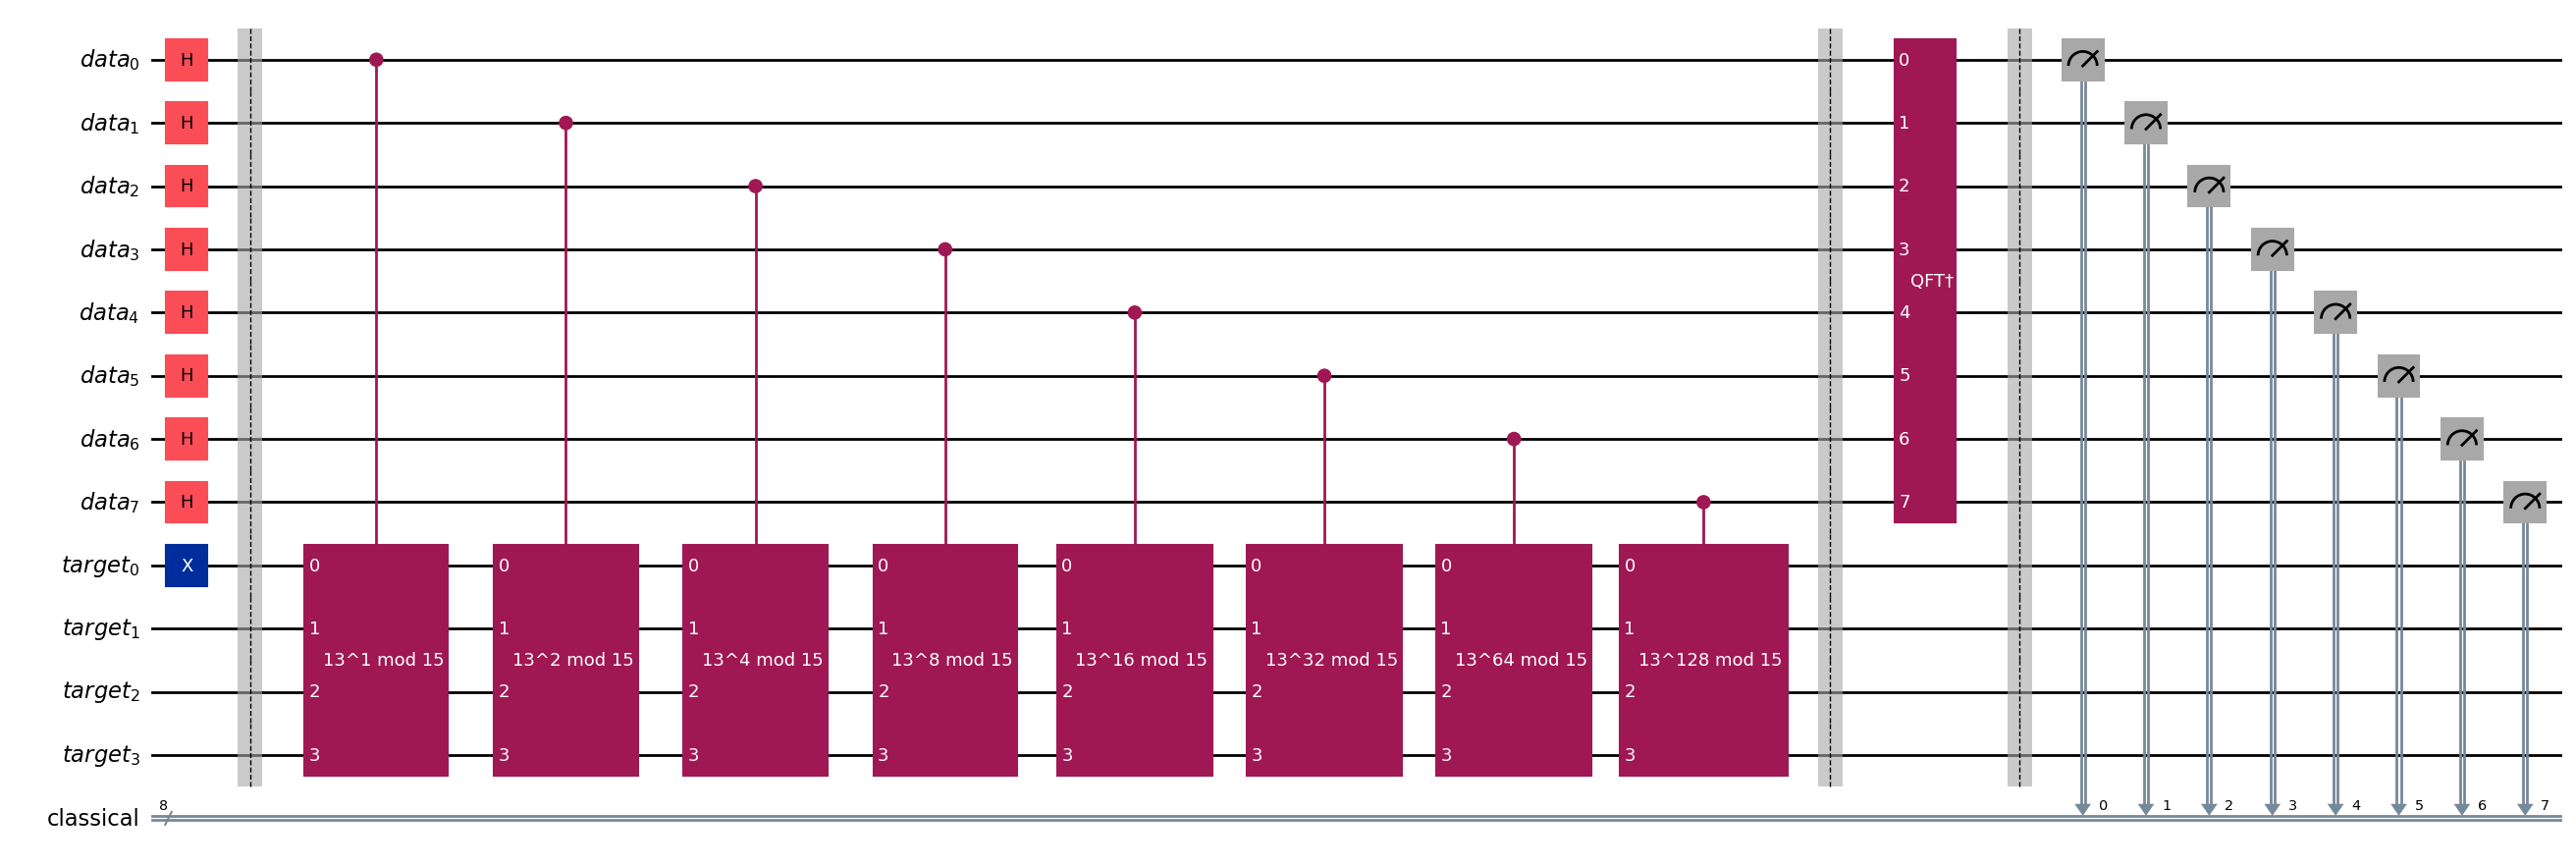

In [212]:
# Value of the module 'N' for this case
N = 15 

# Base 'a' chosen randomly following: a < N & gcd(a,N) == 1
a = random_a(N) 
print('''The exponential selected is: {}^x mod {}'''.format(a,N), flush = True)

# Number of qubits 't' selected  with the relation: t = 2 * log N
num_qubits = 2 * int(np.ceil(np.log2(N)))

# Creation of registers and circuit
data = QuantumRegister(num_qubits, name="data")
target = QuantumRegister(num_qubits//2, name="target")
classical = ClassicalRegister(num_qubits, name="classical")
circuit = QuantumCircuit(data, target, classical)
circuit = qpe(circuit, num_qubits, a)
circuit.draw(output='mpl', fold=-1) 


Once the circuit has been initialized, a simulation is done with the intention of obtaining a "phase value" and then a "period". 
 
From the phase obtained, with a simple fraction the period can be found. This is due to the fact that this phase can be interpreted as the frequency of the operation and, as a consequence, the period ought to be its inverse.

Printing the various results followed by how many times they happened (out of the 1000 cases):

-> Result "10000000" happened 272 times out of 1000
-> Result "00000000" happened 266 times out of 1000
-> Result "11000000" happened 230 times out of 1000
-> Result "01000000" happened 232 times out of 1000


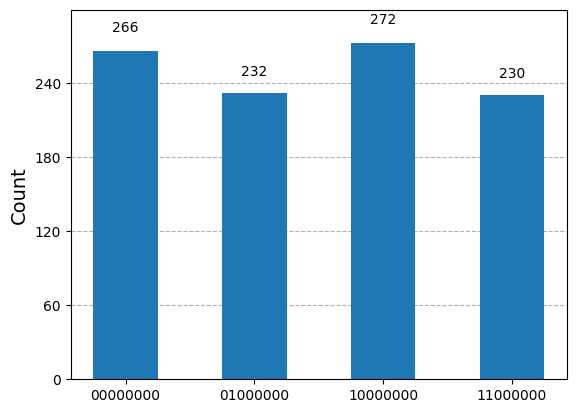

In [213]:
""" To login to IBM Q experience the following functions should be called """
"""
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=2*num_qubits+1)
print("Using the quantum computer backend: " + backend.name)
Shots = 1000
transpiled_circuit = transpile(circuit, backend)
job = backend.run(transpiled_circuit, shots=Shots)
run_result = job.result() # Substitute sim_result by run_result
counts_result = run_result.get_counts()
"""
  
""" NoiseModel Simulation Implementation """
"""
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error

# Create a depolarizing error on the gates
error_gate1 = depolarizing_error(x, 1)  # Reduced error rate to make it more realistic
error_gate2 = depolarizing_error(y, 2)  # Reduced error rate to make it more realistic
error_measure = amplitude_damping_error(z)  # Slightly reduced measurement error
# The values x, y and z are to be decided depending on the noise mode

# Create a noise model and add the errors to the noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_gate1, ['u1', 'u2', 'u3'])  # Add to all single-qubit gates
noise_model.add_all_qubit_quantum_error(error_gate2, ['cx'])  # Add to all two-qubit gates
noise_model.add_all_qubit_quantum_error(error_measure, 'measure')  # Measurement noise

sim = AerSimulator(noise_model=noise_model)
"""
  
sim = AerSimulator()
Shots = 1000
transpiled_circuit = transpile(circuit, backend = sim)
sim_run = sim.run(transpiled_circuit, shots = Shots, memory = True)
sim_result=sim_run.result()
counts_result = sim_result.get_counts()
  
phases = defaultdict(list)
print('''Printing the various results followed by how many times they happened (out of the {} cases):\n'''.format(Shots), flush = True)
for i in range(len(counts_result)):

    print('-> Result \"{0}\" happened {1} times out of {2}'.format(
            list(sim_result.get_counts().keys())[i],
            list(sim_result.get_counts().values())[i],Shots), 
            flush = True)
    phases[list(sim_result.get_counts().keys())[i]].append(
            list(sim_result.get_counts().values())[i])
    
fig, ax = plt.subplots()

# Create the histogram of phase values
plot_histogram(phases, ax=ax) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
# fig.savefig(f'output_{a}x_{Shots}.png')

plt.show()

 
--> Analysing result 10000000. 
---> In decimal, phase value for this result is: 0.5
---> The period found for this result is: 2
 
--> Analysing result 00000000. 
---> In decimal, phase value for this result is: 0.0
---> The period found for this result is: 1
 
--> Analysing result 11000000. 
---> In decimal, phase value for this result is: 0.75
---> The period found for this result is: 4
 
--> Analysing result 01000000. 
---> In decimal, phase value for this result is: 0.25
---> The period found for this result is: 4


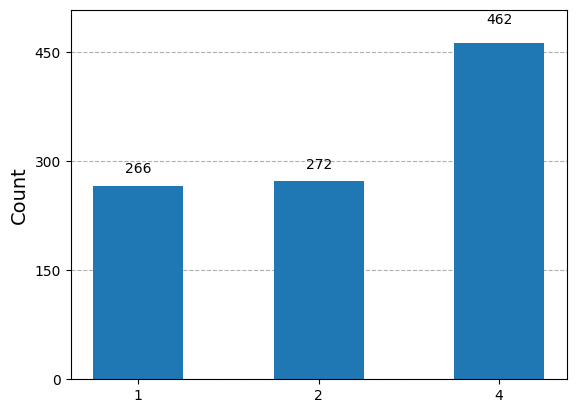

In [214]:
periods = defaultdict(list)
for i in range(len(counts_result)):

    all_registers_output = list(sim_result.get_counts().keys())[i]  
    output_desired = all_registers_output
            
    phase = int(output_desired, 2)/(2**num_qubits)

    if phase != 0:           
        print(' ', flush = True)
        print("--> Analysing result {0}. ".format(output_desired), flush = True)

        """ Print the final phase to user """
        print('---> In decimal, phase value for this result is: {0}'.format(phase), flush = True)

        """ Print the period to user """
        frac = Fraction(phase).limit_denominator(N)
        p, r = frac.numerator, frac.denominator
        print('---> The period found for this result is: {0}'.format(r),  flush = True)     
    else:
        print(' ', flush = True)
        print("--> Analysing result {0}. ".format(output_desired), flush = True)

        """ Print the final phase to user """
        print('---> In decimal, phase value for this result is: {0}'.format(phase), flush = True)

        """ Print the period to user """
        # If the phase is equal to 0.0 this means the function has periodicity of 1
        r = 1 
        print('---> The period found for this result is: {0}'.format(r),  flush = True)

    periods[r].append(list(sim_result.get_counts().values())[i])

fig, ax = plt.subplots()

# Gathering total counts of each period, histogram shown
all_periods = {key: sum(values) for key, values in periods.items()} 
plot_histogram(all_periods, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
# fig.savefig(f'periods_{a}x_{Shots}.png')

plt.show()